In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [ ]:
#imports
import json
import math
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.preprocessing
from sklearn import linear_model
import sklearn.model_selection
from sklearn import preprocessing
from sklearn import svm

# Pre-Processing Data
Initially we tried to only expand certain columns with sub-columns, those being the totals and device columns. However,  after running tests we needed to further expandand incorporate more features.

In [ ]:
# def loadDataFrame(directory, rows, skip = 0):
#     IMPORTANT_COLS = ['totals','device', 'geoNetwork', 'trafficSource']
#     df = pd.read_csv("../input/train_v2.csv",
#                             converters={col: json.loads for col in IMPORTANT_COLS}, #makes those columns data into dictionaries or json objects
#                             dtype={'fullVisitorId': 'str'}, #force it to be a string
#                             nrows = rows,
#                             skiprows = skip
#                     )
#     for c in IMPORTANT_COLS:
#         col_as_df = pd.io.json.json_normalize(df[c])
#         col_as_df.columns = [f"{subcolumn}" for subcolumn in col_as_df.columns]
#         df = df.drop(c, axis=1).merge(col_as_df, right_index=True, left_index=True)
    
#     # drop useless features: date, socialEngagement, visitStartTime
#     df = df.drop(["date", "socialEngagementType", "visitStartTime", "visitId"], axis=1)
#     return df

def ldf(directory, rows, skip=0):
    df = pd.read_csv("../input/train_v2.csv",
                            nrows = rows,
                            skiprows = skip
                    )
    df = df.drop(["date", "socialEngagementType", "visitStartTime", "visitId", "fullVisitorId","hits"], axis=1)
    try:
        devices_df = pd.DataFrame(df.device.apply(json.loads).tolist())[["browser", "operatingSystem", "deviceCategory", "isMobile"]]
    except:
        zero_data = np.zeros(shape=(rows,len(["browser", "operatingSystem", "deviceCategory", "isMobile"])))
        devices_df = pd.DataFrame(zero_data, columns=["browser", "operatingSystem", "deviceCategory", "isMobile"])
    try:
        geo_df = pd.DataFrame(df.geoNetwork.apply(json.loads).tolist())[["continent", "subContinent", "country", "city"]]
    except:
        zero_data = np.zeros(shape=(rows,len(["continent", "subContinent", "country", "city"])))
        geo_df = pd.DataFrame(zero_data, columns=["continent", "subContinent", "country", "city"])
    try:
        traffic_source_df = pd.DataFrame(df.trafficSource.apply(json.loads).tolist())[["keyword", "medium", "source"]]
    except:
        zero_data = np.zeros(shape=(rows,len(["keyword", "medium", "source"])))
        traffic_source_df = pd.DataFrame(zero_data, columns=["keyword", "medium", "source"])
    try:
        totals_df = pd.DataFrame(df.totals.apply(json.loads).tolist())[["transactionRevenue", "newVisits", "bounces", "pageviews", "hits"]]
    except:
        zero_data = np.zeros(shape=(rows,5))
        totals_df = pd.DataFrame(zero_data, columns=["transactionRevenue", "newVisits", "bounces", "pageviews", "hits"])
    
    df = pd.concat([df, devices_df, geo_df, traffic_source_df, totals_df], axis=1)
    df = df.drop(["device", "geoNetwork", "trafficSource", "totals"], axis=1)
    df["transactionRevenue"] = df["transactionRevenue"].fillna(0)
    df["bounces"] = df["bounces"].fillna(0)
    df["pageviews"] = df["pageviews"].fillna(0)
    df["hits"] = df["hits"].fillna(0)
    df["newVisits"] = df["newVisits"].fillna(0)
    
    df["transactionRevenue"] = df["transactionRevenue"].astype(np.float)
    
    cat_features = ['channelGrouping', 'browser', 'operatingSystem', 'deviceCategory', 'isMobile',
                        'continent', 'subContinent', 'country', 'city', 'keyword', 'medium', 
                        'source', 'customDimensions'] #strings -> need to map to floats?
    
    for c in cat_features:
        le = preprocessing.LabelEncoder()
        le.fit(list(df[c].values.astype("str")))
        df[c] = le.transform(list(df[c].values.astype("str")))
    
    numerical_features = ['visitNumber', 'newVisits', 'bounces', 'pageviews', "hits"]
    for c in numerical_features:
        df[c] = df[c].astype(np.float)
    
    return df

# Preliminary Data Observations

In [ ]:
test_rows = 2500
number_rows_read = 15000
dftrain = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
# dftrain = ldf("../input/train_v2.csv", 1000, skip=[1])
print (dftrain.shape)
print (dftrain.dtypes)
print (dftrain.columns)

In [ ]:
dftrain.head()

In [ ]:
print(dftrain.loc[dftrain['transactionRevenue'] != 0.0].head()["transactionRevenue"])
df = dftrain.loc[dftrain['transactionRevenue'] != 0.0]
print(df)
# print(dftrain["transactionRevenue"])

Note that the 80/20 is in effect with our data

In [ ]:
rev = np.array(dftrain["transactionRevenue"])
rev.sort()
plt.figure(figsize=(8,6))
plt.scatter(range(len(rev)), rev)
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

# Linear Regression, Standard Attempt
Results:
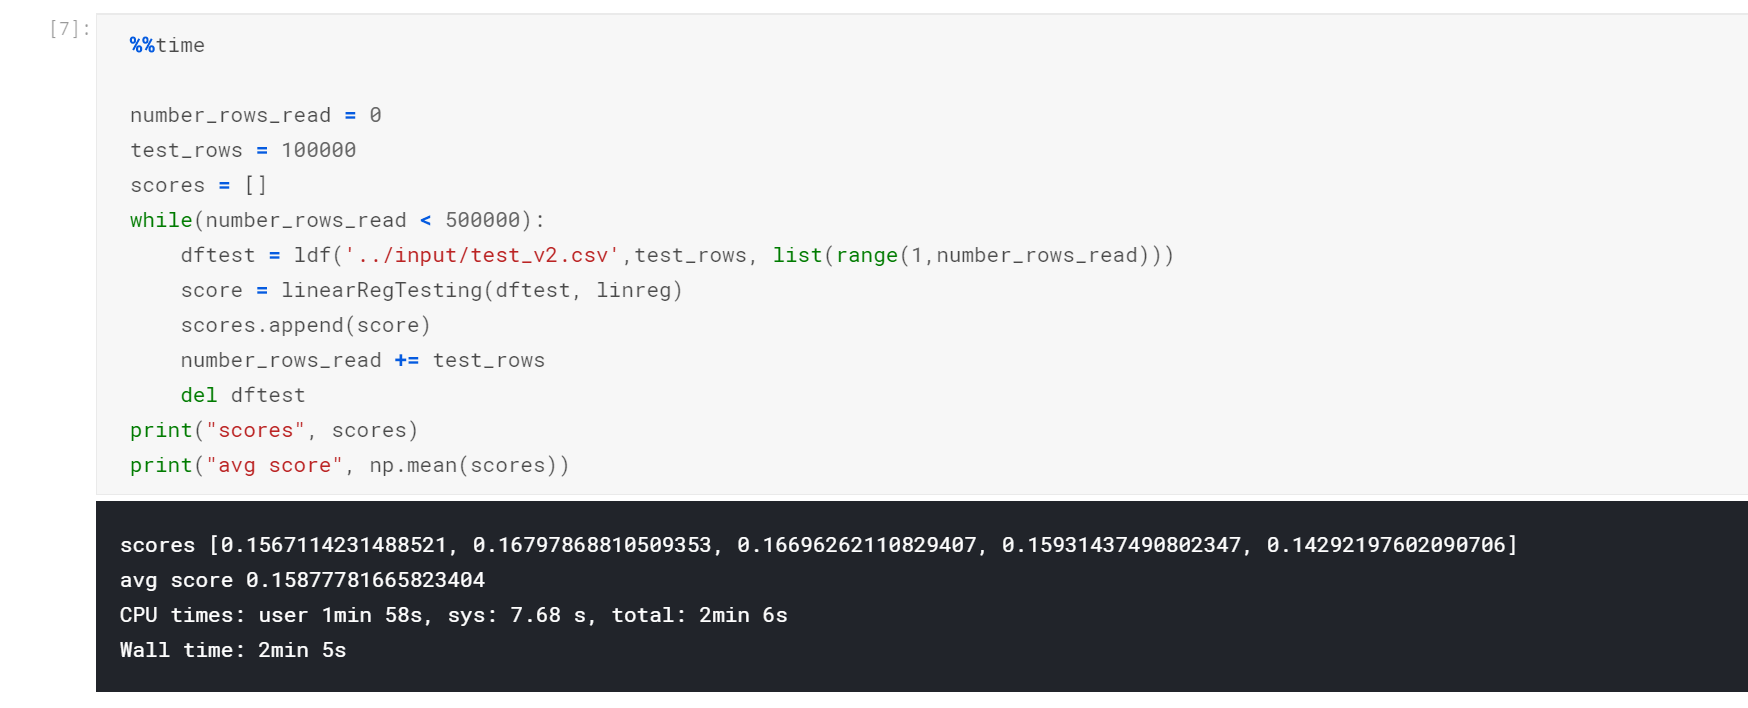

In [ ]:
# def linearRegFitting(dftrain, linreg):
#     unique_customer_dict = {}
#     for row in range(0,dftrain.shape[0]):
#         is_mobile_dev = 1 if dftrain.iloc[row]['isMobile'] else 0
#         channel_grouping = hash(dftrain.iloc[row]['channelGrouping'])
#         full_visitor_id = dftrain.iloc[row]["fullVisitorId"]
#         total_trans_rev = dftrain.iloc[row]['transactionRevenue']
#         the_key = (full_visitor_id, channel_grouping, is_mobile_dev)
#         if the_key in unique_customer_dict.keys():
#             unique_customer_dict[the_key] = unique_customer_dict[the_key] + float(total_trans_rev) if not math.isnan(float(total_trans_rev)) else unique_customer_dict[the_key] + 0
#         else:
#             unique_customer_dict[the_key] = float(total_trans_rev) if not math.isnan(float(total_trans_rev)) else 0

#     unique_ids = set(dftrain["fullVisitorId"])
#     x_tr = []
#     for row in unique_customer_dict.keys():
#         row_mod = np.array([float(row[0]), float(row[1]), float(row[2])])
#         x_tr.append(row_mod)
#     x_tr = np.array(x_tr)

#     y_tr = []
#     for row in unique_customer_dict.values():
#         y_tr.append(row)
#     y_tr = np.array(y_tr)

#     linreg.fit(x_tr, y_tr)
#     print("coeff =", linreg.coef_)
#     print("intercept =", linreg.intercept_)
#     print("-----------")

def linearRegFitting2(dftrain, linreg):
    y_tr = np.log1p(np.array(dftrain["transactionRevenue"]))
    y_tr = y_tr.reshape(y_tr.shape[0],1)
    df = dftrain.drop(["transactionRevenue"], axis=1)
    x_tr = np.array(df)
    linreg.fit(x_tr, y_tr)
    print("coeff =", linreg.coef_)
    print("intercept =", linreg.intercept_)
    print("-----------")
    

In [ ]:
%%time

train_rows = 100000
number_rows_read = 0
linreg = linear_model.LinearRegression()
while(number_rows_read < 500000):
    dftrain2 = ldf('../input/train_v2.csv',train_rows, list(range(1,number_rows_read)))
    linearRegFitting2(dftrain2, linreg)
    number_rows_read += train_rows
    del dftrain2 #remove dataframe from memory once we trained on it

In [ ]:
# def linearRegTesting(dftest, linreg):
#     unique_customer_dict = {}
#     for row in range(0,dftest.shape[0]):
#         is_mobile_dev = 1 if dftest.iloc[row]['device.isMobile'] else 0
#         channel_grouping = hash(dftest.iloc[row]['channelGrouping'])
#         full_visitor_id = dftest.iloc[row]["fullVisitorId"]
#         total_trans_rev = dftest.iloc[row]['totals.transactionRevenue']
#         the_key = (full_visitor_id, channel_grouping, is_mobile_dev)
#         if the_key in unique_customer_dict.keys():
#             unique_customer_dict[the_key] = unique_customer_dict[the_key] + float(total_trans_rev) if not math.isnan(float(total_trans_rev)) else unique_customer_dict[the_key] + 0
#         else:
#             unique_customer_dict[the_key] = float(total_trans_rev) if not math.isnan(float(total_trans_rev)) else 0

#     unique_ids = set(dftrain["fullVisitorId"])
#     x_test = []
#     for row in unique_customer_dict.keys():
#         row_mod = np.array([float(row[0]), float(row[1]), float(row[2])])
#         x_test.append(row_mod)
#     x_test = np.array(x_test)
    
#     y_test = []
#     for row in unique_customer_dict.values():
#         y_test.append(row)
#     y_test = np.array(y_test)
    
#     score = linreg.score(x_test, y_test)
#     return score

def linearRegTesting(dftrain, linreg):
    y_tr = np.log1p(np.array(dftrain["transactionRevenue"]))
    y_test = y_tr.reshape(y_tr.shape[0],1)
    df = dftrain.drop(["transactionRevenue"], axis=1)
    x_test = np.array(df)
    score = linreg.score(x_test, y_test)
    return score

In [ ]:
%%time

number_rows_read = 0
test_rows = 100000
scores = []
while(number_rows_read < 500000):
    dftest = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
    score = linearRegTesting(dftest, linreg)
    scores.append(score)
    number_rows_read += test_rows
    del dftest
print("scores", scores)
print("avg score", np.mean(scores))

# Linear Regression with Lasso

Small Alpha testing

In [ ]:
%%time

train_rows = 100000
number_rows_read = 0
linregLasso = linear_model.Lasso(alpha = 0.001, warm_start = True)
while(number_rows_read < 500000):
    dftrain2 = ldf('../input/train_v2.csv',train_rows, list(range(1,number_rows_read)))
    linearRegFitting2(dftrain2, linregLasso)
    number_rows_read += train_rows
    del dftrain2 #remove dataframe from memory once we trained on it

In [ ]:
%%time

number_rows_read = 0
test_rows = 100000
scores = []
while(number_rows_read < 500000):
    dftest = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
    score = linearRegTesting(dftest, linregLasso)
    scores.append(score)
    number_rows_read += test_rows
    del dftest
print("scores", scores)
print("avg score", np.mean(scores))

Large Alpha testing
- Chose large alpha of 3 so as not to completely get rid of every single parameter (which begins to occur for alphas higher than 5)
- Values attempted: 1000, 10, 5, 3

In [ ]:
%%time

train_rows = 100000
number_rows_read = 0
linregLassoLarge = linear_model.Lasso(alpha = 3, warm_start = True)
while(number_rows_read < 500000):
    dftrain2 = ldf('../input/train_v2.csv',train_rows, list(range(1,number_rows_read)))
    linearRegFitting2(dftrain2, linregLassoLarge)
    number_rows_read += train_rows
    del dftrain2 #remove dataframe from memory once we trained on it

In [ ]:
%%time

number_rows_read = 0
test_rows = 100000
scores = []
while(number_rows_read < 500000):
    dftest = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
    score = linearRegTesting(dftest, linregLassoLarge)
    scores.append(score)
    number_rows_read += test_rows
    del dftest
print("scores", scores)
print("avg score", np.mean(scores))

# Linear Regression with Ridge

## Small Alpha testing

In [ ]:
%%time

train_rows = 100000
number_rows_read = 0
linregRidge = linear_model.Ridge(alpha = 0.001)
while(number_rows_read < 500000):
    dftrain2 = ldf('../input/train_v2.csv',train_rows, list(range(1,number_rows_read)))
    linearRegFitting2(dftrain2, linregRidge)
    number_rows_read += train_rows
    del dftrain2 #remove dataframe from memory once we trained on it

In [ ]:
%%time

number_rows_read = 0
test_rows = 100000
scores = []
while(number_rows_read < 500000):
    dftest = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
    score = linearRegTesting(dftest, linregRidge)
    scores.append(score)
    number_rows_read += test_rows
    del dftest
print("scores", scores)
print("avg score", np.mean(scores))

## Large Alpha testing

In [ ]:
%%time

train_rows = 100000
number_rows_read = 0
linregRidgeLarge = linear_model.Ridge(alpha = 3)
while(number_rows_read < 500000):
    dftrain2 = ldf('../input/train_v2.csv',train_rows, list(range(1,number_rows_read)))
    linearRegFitting2(dftrain2, linregRidgeLarge)
    number_rows_read += train_rows
    del dftrain2 #remove dataframe from memory once we trained on it

In [ ]:
%%time

number_rows_read = 0
test_rows = 100000
scores = []
while(number_rows_read < 500000):
    dftest = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
    score = linearRegTesting(dftest, linregRidgeLarge)
    scores.append(score)
    number_rows_read += test_rows
    del dftest
print("scores", scores)
print("avg score", np.mean(scores))

<h1>SVM Regression</h1>

In [ ]:
def svrTraining(svr, dftrain, kernel):
    y_tr = np.log1p(np.array(dftrain["transactionRevenue"]))
    y_tr = y_tr.reshape(y_tr.shape[0],1)
    df = dftrain.drop(["transactionRevenue"], axis=1)
    x_tr = np.array(df)
    
    svr.fit(x_tr, y_tr)
#     if kernel == 'linear':
#         print("coeff =", svr.coef_)
#     print("intercept =", svr.intercept_)
#     print("-----------")

def svrTest(svr, dftest):
    y_tr = np.log1p(np.array(dftest["transactionRevenue"]))
    y_test = y_tr.reshape(y_tr.shape[0],1)
    df = dftest.drop(["transactionRevenue"], axis=1)
    x_test = np.array(df)
    
    score = svr.score(x_test, y_test)
    return score

# let's figure out what Cs and gammas we want to test first
c_values = [0.001, 0.01, 0.1, 1]
gamma_values = [0.001, 0.01, 0.1, 1]
score_averages = []

## Linear Kernel

In [ ]:
for c in c_values:
    linear_svr = svm.SVR(kernel = 'linear', C = c)

    # training the model
    train_rows = 10000
    number_rows_read = 0
    while(number_rows_read < 20000):
        dftrain = ldf('../input/train_v2.csv',train_rows, list(range(1,number_rows_read)))
        svrTraining(linear_svr, dftrain)
        number_rows_read += train_rows
        del dftrain #remove dataframe from memory once we trained on it
    
   # testing the model
    number_rows_read = 0
    test_rows = 10000
    scores = []
    while(number_rows_read < 20000):
        dftest = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
        score = svrTest(linear_svr, dftest)
        scores.append(score)
        number_rows_read += test_rows
        del dftest
    
    average = np.mean(scores)
    score_averages.append(average)
    
print(score_averages)

## Poly Kernel

In [ ]:
%%time

score_averages = []
for gamma in gamma_values:
    print("gamma =", gamma)
    average_arr = []
    for c in c_values:
        if c == 1:
            continue
        poly_svr = svm.SVR(kernel = 'poly', degree=2, C = c, gamma = gamma)
        print("c =", c)
        
        # training the model
        train_rows = 10000
        number_rows_read_init = 0
        number_rows_read = number_rows_read_init
        limit = 20000
        while(number_rows_read < limit):
            dftrain = ldf('../input/train_v2.csv',train_rows, list(range(1,number_rows_read)))
            svrTraining(poly_svr, dftrain, 'poly')
            number_rows_read += train_rows
            del dftrain #remove dataframe from memory once we trained on it

       # testing the model
        test_rows = train_rows
        number_rows_read = number_rows_read_init
        scores = []
        while(number_rows_read < limit):
            dftest = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
            score = svrTest(poly_svr, dftest)
            scores.append(score)
            number_rows_read += test_rows
            del dftest

        average = np.mean(scores)
        average_arr.append(average)
    print("average_arr", average_arr)
    print("~~~~~~~~~~~~~~")
    score_averages.append(average_arr)
    
print(score_averages)

## RBF Kernel

In [ ]:
%%time

score_averages = []
for gamma in gamma_values:
    print("gamma", gamma)
    average_arr = []
    for c in c_values:
        rbf_svr = svm.SVR(kernel = 'rbf', C = c, gamma = gamma)
        print("c", c)
        # training the model
        train_rows = 10000
        number_rows_read = 0
        while(number_rows_read < 20000):
            dftrain = ldf('../input/train_v2.csv',train_rows, list(range(1,number_rows_read)))
            svrTraining(rbf_svr, dftrain, 'rbf')
            number_rows_read += train_rows
            del dftrain #remove dataframe from memory once we trained on it

       # testing the model
        number_rows_read = 0
        test_rows = 10000
        scores = []
        while(number_rows_read < 20000):
            dftest = ldf('../input/test_v2.csv',test_rows, list(range(1,number_rows_read)))
            score = svrTest(rbf_svr, dftest)
            scores.append(score)
            number_rows_read += test_rows
            del dftest

        average = np.mean(scores)
        average_arr.append(average)
    print("average_arr", average_arr)
    print("~~~~~~~~~~~~~~")
    score_averages.append(average_arr)
    
# print(score_averages)

In [ ]:
for i in range(len(gamma_values)):
    for j in range(len(c_values)):
        print("Gamma =", gamma_values[i], "C =", c_values[j])
        print("Score result =", score_averages[i][j])

In [ ]:
plt.xlabel("gamma")
plt.ylabel("score")
for i in range(len(c_values)):
    plt.semilogx(gamma_values, score_averages[i], label = "C =" + str(c_values[i]))
    
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()